In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import lmfit as lmfit

import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

In [2]:
csvs = glob("./*.csv")
csvs.sort()
print(csvs)


['./N1000epsilon5.0r8.0lz308.5sig1.0nc20824dt0.005bdump1000adump5000-all-rPhiCrd.csv', './N1000epsilon5.0r8.0lz308.5sig1.0nc20824dt0.005bdump1000adump5000-all-rPhiMon.csv', './N1000epsilon5.0r8.0lz308.5sig1.0nc20824dt0.005bdump1000adump5000-all-zPhiCrd.csv', './N1000epsilon5.0r8.0lz308.5sig1.0nc20824dt0.005bdump1000adump5000-all-zPhiMon.csv']


### output file for test python.stepfinder and matlapb.autostepfinder

In [ ]:
phi = pd.read_csv(csvs[3], header=0)
phi_moved = phi.iloc[:,[8,2]]
bin_range = np.ptp(phi_moved.bin_center)
print(bin_range)
phi_moved.loc[:, 'bin_center_moved'] = phi_moved.loc[:,'bin_center'] + 0.5* bin_range
np.savetxt('./ens2.txt',phi_moved.iloc[:,[2,1]].values)

In [ ]:
phi_moved

### lmfit

#### amir squre well model

In [ ]:
#def left_step_function(x, xleft, yleft):
#    return np.where(x <= xleft, 0, yleft)
#def right_step_function(x, xright, yright):
#    return np.where(x <= xright, yright, 0)
def square_well(x, xleft, xright, ymin, ymax):
    return np.where((x <= xleft) | (x >= xright), ymin, ymax)

In [ ]:
x_data = phi.iloc[:,8].to_numpy()
y_data = phi.iloc[:,7].to_numpy()
square_well_model = lmfit.Model(square_well)
params = square_well_model.make_params()
square_well_model.set_param_hint(
    'xleft',
    value=x_data.min()/2,
)
square_well_model.set_param_hint(
    'xright',
    value=x_data.max()/2,
)
square_well_model.set_param_hint(
    'ymin',
    value=y_data.min(),
)
square_well_model.set_param_hint(
    'ymax',
    value=y_data.max(),
)
result = square_well_model.fit(y_data, x=x_data)
print(result.fit_report())

In [ ]:
plt.plot(x_data, y_data)
plt.plot(x_data, square_well(x_data,**result.params), 'r')
plt.plot(x_data, np.heaviside(x_data,0), 'g')
plt.show()

#### scipy.signal.square

In [ ]:
x_data = phi.iloc[:,8].to_numpy()
y_data = phi.iloc[:,7].to_numpy()
def step_function(x, ymin, ymax, width, x_range, reverse):
    y = 0.5 * (ymax-ymin) * (reverse * signal.square(2 * np.pi * x / x_range + width * np.pi, duty=width) +1) + ymin 
    return y

In [ ]:
step_model = lmfit.Model(step_function)
params = step_model.make_params()
step_model.set_param_hint(
    'ymax',
    value=y_data.max(),
)
step_model.set_param_hint(
    'ymin',
    value=y_data.min(),
)
step_model.set_param_hint(
    'width',
    value=0.5,
    min=0.1,
    max=0.9,
)
step_model.set_param_hint(
    'x_range',
    value=np.ptp(x_data),
    vary=False
)
step_model.set_param_hint(
    'reverse',
    value=-1.0,
    vary=False
)

In [ ]:

#y_data = fit.model(x=xdata, **fit_result.params).y
#x_range = np.ptp(x_data)
#params = lmfit.Parameters()
#params.add_many(('ymax', y_data.max()), ('ymin', y_data.min()), ('duty', 0.2))

In [ ]:
#reverse = 1.0
#mi = lmfit.minimize(step_function, params, args=(x_data, x_range, reverse), kws={'y':y_data})

In [ ]:
result = step_model.fit(y_data, x=x_data, width=0.22, reverse=-1.0)

In [ ]:
print(result.fit_report())

In [ ]:
plt.plot(x_data, y_data)
plt.plot(x_data, step_function(x_data,**result.params), 'r')
plt.show()

#### lmfit.RectangleModel

In [3]:
def normalize_z_mon(
    x,
    y,
    half_width
):
    rect_model = lmfit.models.RectangleModel()
    params = rect_model.make_params()
    params = rect_model.guess(y_data, x=x_data, center1=-10, center2=10)
    #params['c'].vary = False # force offset = 1.0 : value away from "dip"
    params['sigma2'].expr = 'sigma1'# force left and right widths to be the same size
    out = rect_model.fit(y_data, params, x=x_data)

##### Mon

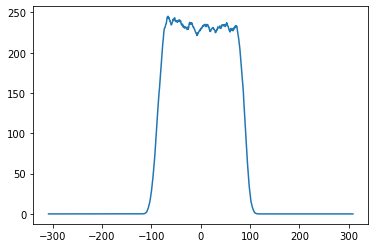

In [4]:
phi = pd.read_csv(csvs[3], header=0)
x_data = phi.iloc[:,8].to_numpy()
y_data = phi.iloc[:,5].to_numpy()
plt.plot(x_data, y_data)

In [5]:
rect_model = lmfit.models.RectangleModel()
params = rect_model.make_params()
params = rect_model.guess(y_data, x=x_data)#, center1=-20, center2=20)
#params['c'].vary = False # force offset = 1.0 : value away from "dip"
params['sigma2'].expr = 'sigma1'# force left and right widths to be the same size
out = rect_model.fit(y_data, params, x=x_data)

In [6]:
print(out.fit_report())

[[Model]]
    Model(rectangle, form='linear')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 75
    # data points      = 1234
    # variables        = 4
    chi-square         = 12379.5513
    reduced chi-square = 10.0646759
    Akaike info crit   = 2853.33881
    Bayesian info crit = 2873.81088
[[Variables]]
    amplitude:  1481.74960 +/- 6.63226025 (0.45%) (init = 245.2333)
    center1:   -102.344864 +/- 0.07989869 (0.08%) (init = 0)
    sigma1:     177.782111 +/- 0.07522228 (0.04%) (init = 88.07143)
    center2:   -74.4184371 +/- 0.08365213 (0.11%) (init = 0)
    sigma2:     177.782111 +/- 0.07522228 (0.04%) == 'sigma1'
    midpoint:  -88.3816505 +/- 0.05204099 (0.06%) == '(center1+center2)/2.0'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, center2) = -0.792
    C(amplitude, center1) = 0.727
    C(sigma1, center2)    = -0.498
    C(center1, sigma1)    = -0.421
    C(center1, center2)   = -0.191
    C(amplitude, sigma1)  = 0.107

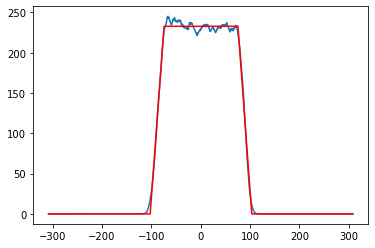

In [7]:
plt.plot(x_data, y_data)
plt.plot(x_data, out.best_fit, 'r')
plt.show()

##### Crd

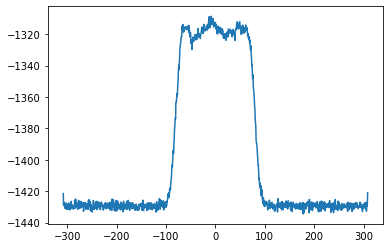

In [42]:
phi = pd.read_csv(csvs[2], header=0)
x_data = phi.iloc[:,8].to_numpy()
y_data = phi.iloc[:,7].to_numpy()
y_trans = -1*phi.iloc[:,7].to_numpy()# + np.max(y_data)
#plt.plot(x_data, -1*y_data)
plt.plot(x_data, y_trans)

In [43]:
rect_model = lmfit.models.RectangleModel(prefix='rect_')
cons_model = lmfit.models.ConstantModel(prefix='cons_')
params = cons_model.make_params(c=y_trans.min())
params = cons_model.guess(y_trans, x=x_data)
params += rect_model.guess(y_trans, x=x_data)
params['rect_sigma2'].expr = 'rect_sigma1'# force left and right widths to be the same size
model = rect_model + cons_model
out = model.fit(y_trans, params, x=x_data)

In [44]:
print(out.fit_report())

[[Model]]
    (Model(rectangle, prefix='rect_', form='linear') + Model(constant, prefix='cons_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 98
    # data points      = 1234
    # variables        = 5
    chi-square         = 7222.20751
    reduced chi-square = 5.87649105
    Akaike info crit   = 2190.35427
    Bayesian info crit = 2215.94435
[[Variables]]
    cons_c:         -1429.21819 +/- 0.08261473 (0.01%) (init = -1400.001)
    rect_amplitude:  735.384785 +/- 5.63400896 (0.77%) (init = 125.8815)
    rect_center1:   -93.5249393 +/- 0.12214341 (0.13%) (init = 0)
    rect_sigma1:     161.992220 +/- 0.11404817 (0.07%) (init = 88.07143)
    rect_center2:   -69.0108828 +/- 0.12479440 (0.18%) (init = 0)
    rect_sigma2:     161.992220 +/- 0.11404817 (0.07%) == 'rect_sigma1'
    rect_midpoint:  -81.2679111 +/- 0.07849512 (0.10%) == '(rect_center1+rect_center2)/2.0'
[[Correlations]] (unreported correlations are < 0.100)
    C(rect_amplitude, rect_center2) 

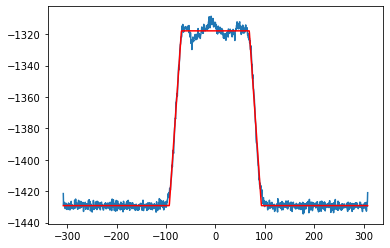

In [45]:
plt.plot(x_data, y_trans)
plt.plot(x_data, out.best_fit, 'r')
plt.show()

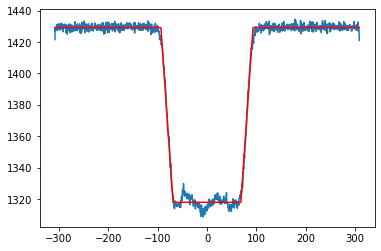

In [46]:
plt.plot(x_data, y_data)
plt.plot(x_data, -1*out.best_fit, 'r')
plt.show()

### scipy optimize

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from numpy.random import normal
from scipy.optimize import least_squares

def square_wave(x, f, a, h, phi):
    return h + a * np.sign(np.cos( 2 * np.pi *f * x + phi ) )

def soft_wave( x, f, a, h, phi, s=1 ):
    return h + a * np.tanh( s * np.cos( 2 * np.pi *f * x + phi ) )

def residuals(params, xdata, ydata, s ):
    f, a, h, phi = params
    yt = soft_wave( xdata, f, a, h, phi, s=s )
    return yt - ydata


#tl = np.linspace( -2, 8.3, 67 )
soldict = dict()
swdict=dict()
previous = ( 0.4, 4, 2, 0 )
tl = phi.iloc[:,8].to_numpy()
sl = square_wave( tl, 0.39, 3.6, 2.1, 0.25 )
#sl += normal( size=len(tl), scale=0.2 )
#swl = soft_wave( tl, 0.39, 3.6, 2.1, 0.25, s=10 )
for mys in range( 2, 26, 4 ):
    res = least_squares(residuals, x0=previous, args=( tl, sl, mys ) )
    print( res.x )
    previous = res.x
    soldict[mys] = np.append( res.x, mys )
    swdict[mys] = soft_wave( tl, *( soldict[mys] ) )

print (np.linalg.inv( np.dot( np.transpose( res.jac ), res.jac ) ) )

fig = plt.figure( figsize=(10,6))
ax= fig.add_subplot( 1, 1, 1 )
ax.plot( tl, sl, ls='', marker='+' )
##ax.plot( tl, swl )
#for mys in range( 2, 26, 4 ):
#    ax.plot( tl,swdict[mys] )
plt.show( )

### simfit

In [ ]:
fit.model(x=xdata, **fit_result.params).y

In [ ]:
from symfit import parameters, variables, sin, cos, Fit
import numpy as np
import matplotlib.pyplot as plt

def fourier_series(x, f, n=0):
    """
    Returns a symbolic fourier series of order `n`.

    :param n: Order of the fourier series.
    :param x: Independent variable
    :param f: Frequency of the fourier series
    """
    # Make the parameter objects for all the terms
    a0, *cos_a = parameters(','.join(['a{}'.format(i) for i in range(0, n + 1)]))
    sin_b = parameters(','.join(['b{}'.format(i) for i in range(1, n + 1)]))
    # Construct the series
    series = a0 + np.sum(ai * cos(i * f * x) + bi * sin(i * f * x)
                     for i, (ai, bi) in enumerate(zip(cos_a, sin_b), start=1))
    return series

x, y = variables('x, y')
w, = parameters('w')
model_dict = {y: fourier_series(x, f=w, n=13)}
print(model_dict)

# Make step function data
x_center = phi.iloc[:,8].to_numpy()
x_range = np.ptp(x_center)
#xdata = np.linspace(-np.pi, np.pi)
xdata = np.linspace(-0.5 * x_range, 0.5 * x_range, num=len(x_center)) * 2 * np.pi / x_range + 0.5 * x_range
#ydata = 2 + np.zeros_like(xdata)
#ydata[xdata > 0] = 12
ydata = phi.iloc[:,7].to_numpy()
# Define a Fit object for this model and data
fit = Fit(model_dict, x=xdata, y=ydata)
fit_result = fit.execute()
print(fit_result)

# Plot the result
plt.plot(xdata, ydata)
plt.plot(xdata, fit.model(x=xdata, **fit_result.params).y, ls=':')
plt.xlabel('x')
plt.ylabel('y')
plt.show()